In [1]:
from pathlib import Path
import os
from os import path as osp
import json

import cv2
from moviepy import *
#conda install -c conda-forge ffmpeg
from PIL import Image
import webvtt
import whisper

from utils import (
    download_video, 
    get_transcript_vtt,
    download_youtube_subtitle,
    get_video_id_from_url,
    str2time,
    maintain_aspect_ratio_resize,
    getSubs,
    encode_image,
)

In [2]:
from dotenv import load_dotenv
import os

load_dotenv()

True

## Preprocess videos with transcript available

In [3]:
video_url = "https://www.youtube.com/watch?v=7Hcg-rLYwdM"
video_dir = "./shared_data/videos/video1"

# download Youtube video to ./shared_data/videos/video1
video_filepath = download_video(video_url, video_dir)

# download Youtube video's subtitle to ./shared_data/videos/video1
video_transcript_filepath = download_youtube_subtitle(video_url, video_dir)

Getting video information for https://www.youtube.com/watch?v=7Hcg-rLYwdM


In [4]:
def extract_and_save_frames_and_metadata(
        path_to_video, 
        path_to_transcript, 
        path_to_save_extracted_frames,
        path_to_save_metadatas):
    
    # metadatas will store the metadata of all extracted frames
    metadatas = []

    # load video using cv2
    video = cv2.VideoCapture(path_to_video)
    # load transcript using webvtt
    trans = webvtt.read(path_to_transcript)
    
    # iterate transcript file
    for idx, transcript in enumerate(trans):
        
        # get the start time and end time in seconds
        start_time_ms = str2time(transcript.start)
        end_time_ms = str2time(transcript.end)
        
        # get the time in ms exactly 
        # in the middle of start time and end time
        mid_time_ms = (end_time_ms + start_time_ms) / 2
        # get the transcript, remove the next-line symbol
        text = transcript.text.replace("\n", ' ')
        # get frame at the middle time
        video.set(cv2.CAP_PROP_POS_MSEC, mid_time_ms)
        success, frame = video.read()
        
        if success:
            # if the frame is extracted successfully, resize it
            image = maintain_aspect_ratio_resize(frame, height=350)
            # save frame as JPEG file
            img_fname = f'frame_{idx}.jpg'
            img_fpath = osp.join(
                path_to_save_extracted_frames, img_fname
            )
            cv2.imwrite(img_fpath, image)

            # prepare the metadata
            metadata = {
                'extracted_frame_path': img_fpath,
                'transcript': text,
                'video_segment_id': idx,
                'video_path': path_to_video,
                'mid_time_ms': mid_time_ms,
            }
            metadatas.append(metadata)

        else:
            print(f"ERROR! Cannot extract frame: idx = {idx}")

    # save metadata of all extracted frames
    fn = osp.join(path_to_save_metadatas, 'metadatas.json')
    with open(fn, 'w') as outfile:
        json.dump(metadatas, outfile)
    return metadatas

In [5]:
video_url = "https://www.youtube.com/watch?v=7Hcg-rLYwdM"
video_dir = "./shared_data/videos/video1"

In [6]:
# output paths to save extracted frames and their metadata 
extracted_frames_path = osp.join(video_dir, 'extracted_frame')
metadatas_path = video_dir

# create these output folders if not existing
Path(extracted_frames_path).mkdir(parents=True, exist_ok=True)
Path(metadatas_path).mkdir(parents=True, exist_ok=True)

# call the function to extract frames and metadatas
metadatas = extract_and_save_frames_and_metadata(
                video_filepath, 
                video_transcript_filepath,
                extracted_frames_path,
                metadatas_path,
            )

In [7]:
metadatas[0:5]

[{'extracted_frame_path': './shared_data/videos/video1/extracted_frame/frame_0.jpg',
  'transcript': "As I look back on the the mission that we've had here",
  'video_segment_id': 0,
  'video_path': './shared_data/videos/video1/Welcome back to Planet Earth.mp4',
  'mid_time_ms': 5249.5},
 {'extracted_frame_path': './shared_data/videos/video1/extracted_frame/frame_1.jpg',
  'transcript': "on the International Space Station, I'm proud to have been a part of much of",
  'video_segment_id': 1,
  'video_path': './shared_data/videos/video1/Welcome back to Planet Earth.mp4',
  'mid_time_ms': 8719.0},
 {'extracted_frame_path': './shared_data/videos/video1/extracted_frame/frame_2.jpg',
  'transcript': 'the science activities that happened over the last',
  'video_segment_id': 2,
  'video_path': './shared_data/videos/video1/Welcome back to Planet Earth.mp4',
  'mid_time_ms': 12119.0},
 {'extracted_frame_path': './shared_data/videos/video1/extracted_frame/frame_3.jpg',
  'transcript': 'two months

In [8]:
len(metadatas)

26

## Preprocess videos with no transcripts available

In [9]:
# Download FFmpeg for moviepy import to work
from moviepy import VideoFileClip

In [10]:
# Declare where to save .mp3 audio
path_to_extracted_audio_file = os.path.join(video_dir, 'audio.mp3')
path_to_extracted_audio_file

'./shared_data/videos/video1/audio.mp3'

In [11]:
# Extract mp3 audio file from mp4 video video file
clip = VideoFileClip(video_filepath)
clip.audio.write_audiofile(path_to_extracted_audio_file)

MoviePy - Writing audio in ./shared_data/videos/video1/audio.mp3


MoviePy - Done.


In [12]:
!which ffmpeg

/opt/homebrew/bin/ffmpeg


In [13]:
model = whisper.load_model("small")
options = dict(task="translate", best_of=1, language='en')
results = model.transcribe(path_to_extracted_audio_file, **options)

/Users/ron/Documents/github/Multimodal-RAG-BTM/multimodal/lib/python3.13/site-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


In [14]:
path_to_extracted_audio_file

'./shared_data/videos/video1/audio.mp3'

In [15]:
results.keys()

dict_keys(['text', 'segments', 'language'])

In [16]:
results['segments'][0]

{'id': 0,
 'seek': 0,
 'start': 0.0,
 'end': 8.78,
 'text': " As I look back on the mission that we've had here on the International Space Station,",
 'tokens': [50364,
  1018,
  286,
  574,
  646,
  322,
  264,
  4447,
  300,
  321,
  600,
  632,
  510,
  322,
  264,
  9157,
  8705,
  14467,
  11,
  50803],
 'temperature': 0.0,
 'avg_logprob': -0.19984712908344884,
 'compression_ratio': 1.5811965811965811,
 'no_speech_prob': 0.15311092138290405}

In [17]:
len(results['segments'])

23

In [18]:
vtt = getSubs(results["segments"], "vtt")
# path to save generated transcript of video1
path_to_generated_trans = osp.join(video_dir, 'generated_captions.vtt')

# write transcription to file
with open(path_to_generated_trans, 'w') as f:
    f.write(vtt)

In [19]:
vtt

"WEBVTT\n\n00:00.000 --> 00:08.780\n As I look back on the mission that we've had here on the International Space Station,\n\n00:08.780 --> 00:13.300\n I'm proud to have been a part of much of the science activities that happened over the\n\n00:13.300 --> 00:14.300\n last two months.\n\n00:14.300 --> 00:16.180\n The view is always amazing though.\n\n00:16.180 --> 00:21.260\n I didn't think I would do another spacewalk and to now have the chance to have done four\n\n00:21.260 --> 00:24.980\n more was just icing on the cake for a wonderful mission.\n\n00:25.480 --> 00:26.980\n The tenth one, do you like the first one?\n\n00:26.980 --> 00:27.980\n No.\n\n00:27.980 --> 00:30.280\n A little more comfortable on your tenth one.\n\n00:30.280 --> 00:36.980\n It's hard to put into words just what it was like to be a part of this expedition, the\n\n00:36.980 --> 00:37.980\n Expedition 63.\n\n00:37.980 --> 00:42.280\n It'll be kind of a memory that will last a lifetime for me.\n\n00:42.280 --> 00:

In [20]:
video_dir

'./shared_data/videos/video1'

In [21]:
with open(path_to_generated_trans, 'r') as file:
    for i, line in enumerate(file):
        if i >= 20:  # Adjust the number of lines you want to display
            break
        print(line.strip())

WEBVTT

00:00.000 --> 00:08.780
As I look back on the mission that we've had here on the International Space Station,

00:08.780 --> 00:13.300
I'm proud to have been a part of much of the science activities that happened over the

00:13.300 --> 00:14.300
last two months.

00:14.300 --> 00:16.180
The view is always amazing though.

00:16.180 --> 00:21.260
I didn't think I would do another spacewalk and to now have the chance to have done four

00:21.260 --> 00:24.980
more was just icing on the cake for a wonderful mission.



## Preprocessing videos with no voice-over

In [22]:
import os
from mistralai import Mistral

def lvlm_inference(lvlm_prompt, base64_image):
    
    # Retrieve the API key from environment variables
    api_key = os.getenv("MISTRAL_API_KEY")

    # Initialize the Mistral client
    client = Mistral(api_key=api_key)

    # Define the messages for the chat
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": lvlm_prompt
                },
                {
                    "type": "image_url",
                    "image_url": f"data:image/jpeg;base64,{base64_image}" 
                }
            ]
        }
    ]

    # Get the chat response
    chat_response = client.chat.complete(
        model="pixtral-12b-2409",
        messages=messages
    )

    # Print the content of the response
    return chat_response.choices[0].message.content

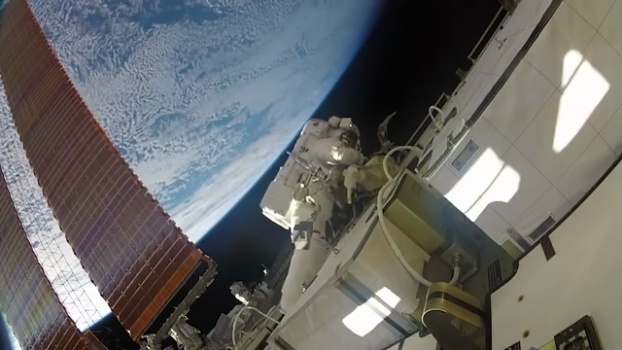

In [23]:
lvlm_prompt = "Can you describe the image?"
path_to_frame = osp.join(video_dir, "extracted_frame", "frame_5.jpg")
frame = Image.open(path_to_frame)
frame

In [24]:
path_to_frame

'./shared_data/videos/video1/extracted_frame/frame_5.jpg'

In [25]:
image = encode_image(path_to_frame)
caption = lvlm_inference(lvlm_prompt, image)
print(caption)

Certainly! The image appears to be taken from space, showing a part of the International Space Station (ISS). There's an astronaut in a spacesuit, seemingly floating outside the ISS. The backdrop features a stunning view of Earth with its blue oceans and white clouds. The ISS structure, including solar panels and other equipment, is visible. The sunlight is shining brightly, illuminating parts of the ISS and casting shadows.


In [26]:
!wget https://raw.githubusercontent.com/Resh-97/multimodal-rag-tutorials/refs/heads/main/src/mm_rag.ipynb

--2025-08-05 08:16:57--  https://raw.githubusercontent.com/Resh-97/multimodal-rag-tutorials/refs/heads/main/src/mm_rag.ipynb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8002::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1425431 (1.4M) [text/plain]
Saving to: ‘mm_rag.ipynb’

mm_rag.ipynb        100%[===================>]   1.36M  2.00MB/s    in 0.7s    

2025-08-05 08:16:58 (2.00 MB/s) - ‘mm_rag.ipynb’ saved [1425431/1425431]



In [27]:
!wget https://raw.githubusercontent.com/Resh-97/multimodal-rag-tutorials/refs/heads/main/src/embedding_creation.ipynb

--2025-08-05 08:18:54--  https://raw.githubusercontent.com/Resh-97/multimodal-rag-tutorials/refs/heads/main/src/embedding_creation.ipynb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8002::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35841972 (34M) [text/plain]
Saving to: ‘embedding_creation.ipynb’

embedding_creation. 100%[===================>]  34.18M  8.67MB/s    in 4.5s    

2025-08-05 08:19:04 (7.54 MB/s) - ‘embedding_creation.ipynb’ saved [35841972/35841972]

